In [2]:
import pandas as pd
data = pd.read_csv('Astronomy_institutes_list - Institute_with_location.csv')
# file is/will be included in github.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               115 non-null    object 
 1   URL                115 non-null    object 
 2   Building_Location  67 non-null     object 
 3   Location           103 non-null    object 
 4   Region             97 non-null     object 
 5   Independency       106 non-null    object 
 6   Job_opportunities  47 non-null     object 
 7   Colloquiums        13 non-null     object 
 8   OCW                1 non-null      object 
 9   latitude           115 non-null    float64
 10  longitude          115 non-null    float64
dtypes: float64(2), object(9)
memory usage: 10.0+ KB


In [ ]:
# Auto-fill longitude and latitude (Not accurate due to language and map source)
from geopy.geocoders import Nominatim
import time

latitude = []
longitude = []

geolocator = Nominatim(user_agent="") #use your agent here. e.g. your e-mail address

for item in data.iterrows():
    time.sleep(1) # Avoiding too frequent request
    try:
        location = geolocator.geocode(item[1][2])
        print(item[1][0],(location.latitude, location.longitude))
        latitude.append(location.latitude)
        longitude.append(location.longitude)
        
    except AttributeError:
        print(item[1][0]+'  Cannot found'+'\n'+'Using campus location...')
        try: 
            location = geolocator.geocode(item[1][3])
            print(item[1][0],(location.latitude, location.longitude))
            latitude.append(location.latitude)
            longitude.append(location.longitude)
        except AttributeError:
            print(item[1][0]+'  Cannot found'+'\n'+'Using Name location...')
            location = geolocator.geocode(item[1][0])
            print(item[1][0],(location.latitude, location.longitude))
            latitude.append(location.latitude)
            longitude.append(location.longitude)


In [ ]:
# Append auto-fill coordinates
data['latitude'] = latitude
data['longitude'] = longitude

How many most common words to print: 10

The 10 most common words are as follows

Astrophysics :  73
Cosmology :  66
Astronomy :  43
Stars :  37
Galaxies :  37
Energy :  34
Formation :  31
High :  30
Physics :  29
Stellar :  28


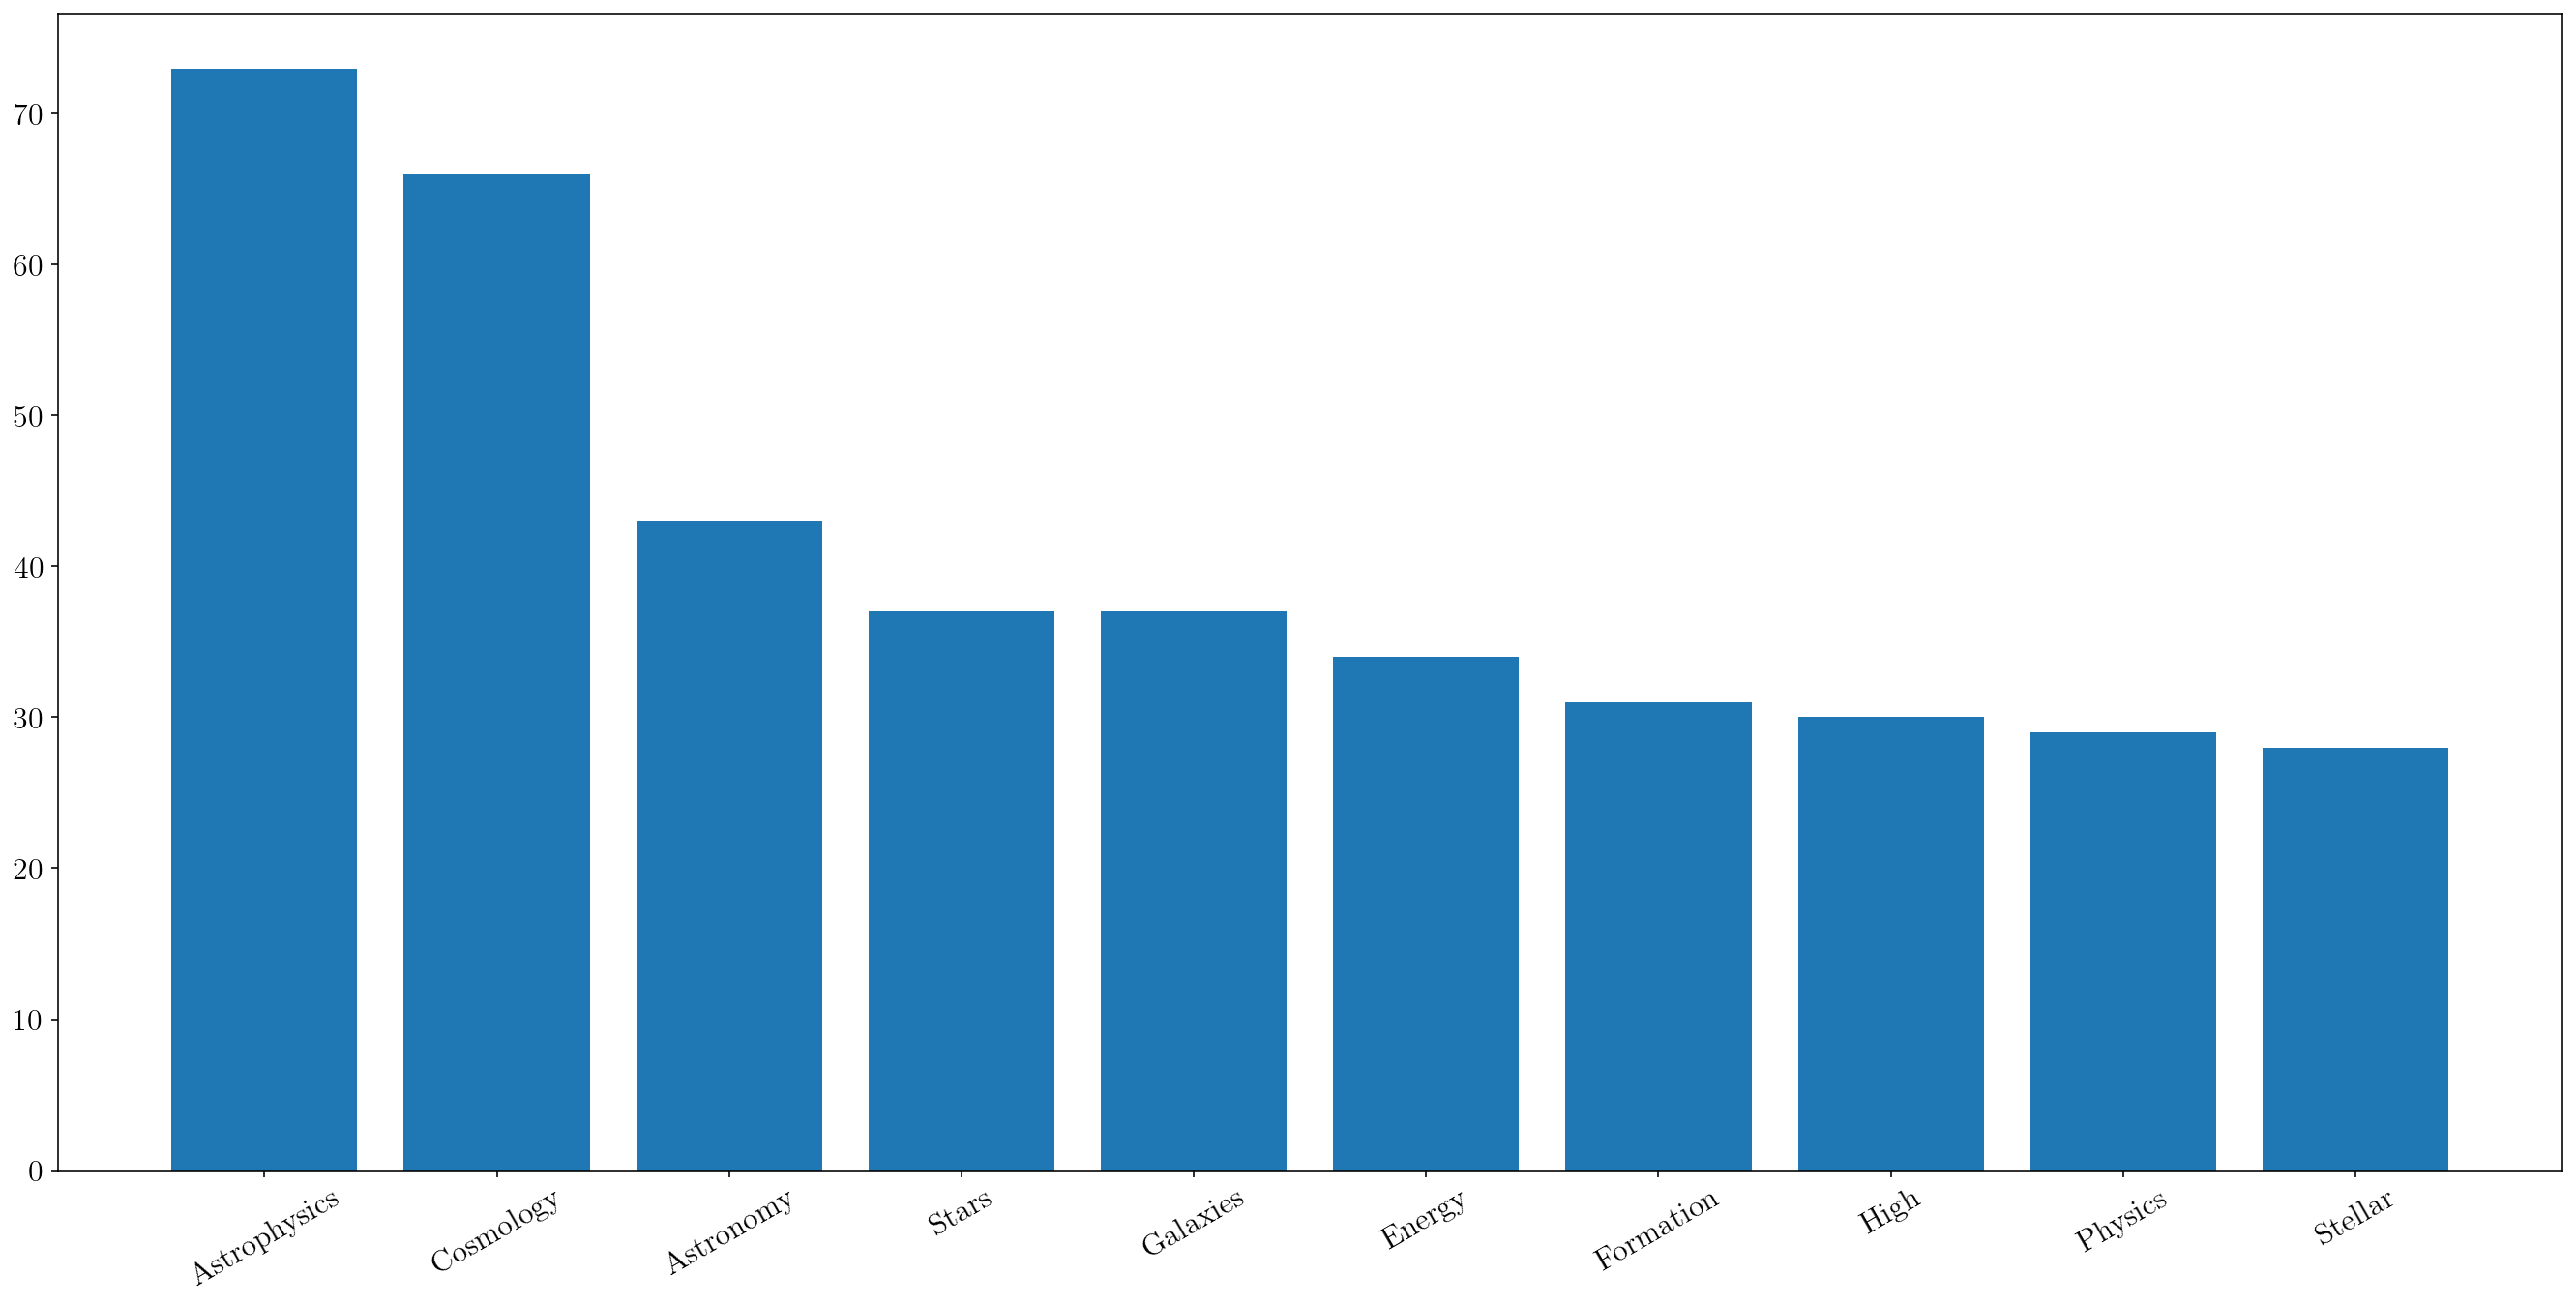

In [3]:
# Check frequent key words in research area
import re
import math

# function check if the research area is not empty
def isNaN(string):
    return string != string

keywords = []
for index,item in data.iterrows():
    if isNaN(item['Region']):
        continue
    for region in re.findall(r"[\w']+", item['Region']):
        if region.title() in ['The','And','Of']: # Don't count these words
            continue
        else:
            keywords.append(region.title())


wordcount = {}

import collections
for word in keywords:
    if word not in wordcount:
        wordcount[word] = 1
    else:
        wordcount[word] += 1

# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nThe {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)

# Create a data frame of the most common words 
# Draw a bar chart
#set up plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)    # Latex support
plt.rc('font', family='serif')
plt.rc('lines', linewidth=0.5) # Linewidth of data
plt.rc('savefig', dpi=300)
fig = plt.figure()
fig.set_size_inches(23.2,11)

#plot
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
plt.bar(df.Word,df.Count)
plt.xticks(rotation=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [4]:
# Creating institute map
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import re

center = [23, 121] # Initial center coordinates
map_institute = folium.Map(location=center, zoom_start=7 , tiles=None)  # zoom_start is the initial zoom factor

# Base map list from http://leaflet-extras.github.io/leaflet-providers/preview/
folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}',
                          attr = 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community'
                 , name='Import Tiles').add_to(map_institute)


# Create map with group marker
mcg = folium.plugins.MarkerCluster(control=False)
map_institute.add_child(mcg)

# Show all intitutes at first
touts = folium.plugins.FeatureGroupSubGroup(mcg, "All",show=True)
map_institute.add_child(touts)

# Creating individual marker(institutes)
for index, institute in data.iterrows():
    location = [institute['latitude'], institute['longitude']]
    html = ('<a href='+str(institute['URL'])+ ' target="_blank">'+str(institute['Name'])+'</a>'+'<br>'+
            '<a href='+str(institute['Job_opportunities'])+ ' target="_blank">'+'Job Opportunity '+'</a>'+'<br>'
            +'<p>'+'Research area: '+'<br>'+str(institute['Region']).title().replace(',','<br>')+'</p>')
    # Set up the window size
    iframe = folium.IFrame(html,
                       width=2200,
                       height=120)
    popup = folium.Popup(iframe,
                     max_width=300)
    if str(institute['Independency']) == 'Yes':
        folium.Marker(location,tooltip=str(institute['Name'])+'<br>'+'Independency: '+'&#9989;'
                      ,popup = popup, icon=folium.Icon(icon='university', prefix='fa')
                     ).add_to(touts) #icon list from https://fontawesome.com/icons?d=gallery
    elif str(institute['Independency']) == 'No':
        folium.Marker(location,tooltip=str(institute['Name'])+'<br>'+'Independency: '+'&#10062;'
                      ,popup = popup, icon=folium.Icon(icon='university', prefix='fa')
                     ).add_to(touts)
    else:
        folium.Marker(location,tooltip=str(institute['Name'])+'<br>'+'Independency: '+'&#x25a2;'
                      ,popup = popup, icon=folium.Icon(icon='university', prefix='fa')
                     ).add_to(touts)

# Check if research area is empty in the list
def isNaN(string):
    return string != string    

# Creating different research area groups in the map
def catalogs(keyword,catalogue): # key word for boolean institutes ['keyword'], catalogue is the research area name
    for index, item in data.iterrows():
        if isNaN(item['Region']):
            continue
        else:
            keys = re.findall(r"[\w']+", item['Region'])
            keys = [word.title() for word in keys]
            location = [item['latitude'], item['longitude']]
            html = ('<a href='+str(item['URL'])+ ' target="_blank">' +str(item['Name'])+'</a>'+'<br>'+
                '<a href='+str(item['Job_opportunities'])+ ' target="_blank">'+'Job Opportunity '+'</a>'+'<br>'
                +'<p>'+'Research area: '+'<br>'+str(item['Region'].title()).replace(',','<br>')+'</p>')
            iframe = folium.IFrame(html,
                               width=2200,
                               height=170)
            popup = folium.Popup(iframe,
                             max_width=300)
            if any(set(keyword)&set(keys)):
                if str(item['Independency']) == 'Yes':
                    folium.Marker(location,tooltip=str(item['Name'])+'<br>'+'Independency: '+'&#9989;'
                                  ,popup = popup, icon=folium.Icon(icon='university', prefix='fa')
                                 ).add_to(catalogue) #icon list from https://fontawesome.com/icons?d=gallery
                elif str(item['Independency']) == 'No':
                    folium.Marker(location,tooltip=str(item['Name'])+'<br>'+'Independency: '+'&#10062;'
                                  ,popup = popup, icon=folium.Icon(icon='university', prefix='fa')
                                 ).add_to(catalogue)
                else:
                    folium.Marker(location,tooltip=str(item['Name'])+'<br>'+'Independency: '+'&#x25a2;'
                                  ,popup = popup, icon=folium.Icon(icon='university', prefix='fa')
                                 ).add_to(catalogue)

# Adding/deleting groups here
instr = folium.plugins.FeatureGroupSubGroup(mcg, "Instrumentation",show=False)
map_institute.add_child(instr)
catalogs(['Instrumentation'],instr)

transient = folium.plugins.FeatureGroupSubGroup(mcg, "Transients",show=False)
map_institute.add_child(transient)
catalogs(['Transient','Supernova','Supernovae','Flare'],transient)

GW = folium.plugins.FeatureGroupSubGroup(mcg, "Gravitational waves",show=False)
map_institute.add_child(GW)
catalogs(['Gravitational','Gw'],GW)

planetary = folium.plugins.FeatureGroupSubGroup(mcg, "Planetary science",show=False)
map_institute.add_child(planetary)
catalogs(['Planetary','Planet','Exoplanet'],planetary)

solar = folium.plugins.FeatureGroupSubGroup(mcg, "Solar system",show=False)
map_institute.add_child(solar)
catalogs(['Solar','Planet','Jupiter','Sun','Earth'],solar)

folium.LayerControl(collapsed=False).add_to(map_institute) # collapsed controls the option is folded or unfolded

#display the map
map_institute

In [5]:
# Save the html file
map_institute.save("map.html")
map_institute.save("index.html")